for later deletion

In [2]:
import os
# need to change my working directory to the one where this script is located and that is in ./WinsorCAM
notebook_dir = os.getcwd()  # Get current working directory
os.chdir(os.path.join(notebook_dir, 'WinsorCAM'))


# This is the code for testing the WinsorCAM on the PASCAL VOC dataset

## These are imports that are needed for the code to run

In [ ]:
from models import ResNet50Modified, Dense121Modified, InceptionV3Modified, VGG16Modified
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow, show
import os
import random
import numpy as np
import torch
from torchvision.datasets import VOCSegmentation
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import imageio
import shutil
from tqdm import tqdm
from skimage import filters

## This code sets the deterministic seed for reproducibility

### Here you must set if you are using VGG16 or InceptionV3
InceptionV3 uses 299x299 images and this will be needed for the data loader
If you are using VGG16 there is an issue where setting the deterministic seed will not work due to some of the layers not supporting set determinism

In [ ]:
# !!! THIS IS VERY IMPORTANT TO SET !!!

inception = False
vgg = False

In [ ]:
def set_deterministic(cpu_only=False):
    # Set all seeds
    seed = 42
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # These settings apply to both CPU and GPU
    torch.use_deterministic_algorithms(True)
    
    # Control CPU threading (important for CPU determinism)
    torch.set_num_threads(1)  # Single thread is most deterministic
    
    # GPU-specific settings (skip if CPU only)
    if not cpu_only:
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
        os.environ["CUDNN_DETERMINISTIC"] = "1"
        os.environ["PYTHONHASHSEED"] = str(seed)

if not vgg:
    set_deterministic(cpu_only=False)
    

## This code gets the data from the PASCAL VOC validation set for testing

Please set the download= True if you need the download the dataset or False if you already have it downloaded

Also set the root = '/path/to/dataset' to the path where you would like to download the dataset

In [5]:
# I need to get the pascal voc dataset

dataset_val = VOCSegmentation(
    root='../data/voc_val',
    year='2012',
    image_set='val',
    download=False)

### This get the class names from the PASCAL VOC dataset

In [6]:
pascal_voc_classes = {
    "[0, 0, 0]": ("background", 0),
    "[128, 0, 0]": ("aeroplane", 1),
    "[0, 128, 0]": ("bicycle", 2),
    "[128, 128, 0]": ("bird", 3),
    "[0, 0, 128]": ("boat", 4),
    "[128, 0, 128]": ("bottle", 5),
    "[0, 128, 128]": ("bus", 6),
    "[128, 128, 128]": ("car", 7),
    "[64, 0, 0]": ("cat", 8),
    "[192, 0, 0]": ("chair", 9),
    "[64, 128, 0]": ("cow", 10),
    "[192, 128, 0]": ("diningtable", 11),
    "[64, 0, 128]": ("dog", 12),
    "[192, 0, 128]": ("horse", 13),
    "[64, 128, 128]": ("motorbike", 14),
    "[192, 128, 128]": ("person", 15),
    "[0, 64, 0]": ("pottedplant", 16),
    "[128, 64, 0]": ("sheep", 17),
    "[0, 192, 0]": ("sofa", 18),
    "[128, 192, 0]": ("train", 19),
    "[0, 64, 128]": ("tvmonitor", 20)
}


classes = [x[0] for x in pascal_voc_classes.values()][1:]
print(classes)

['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


### This code sets the data loader for the PASCAL VOC dataset
This only gets just the validation images with one class and the indexes are defined in single_class_indices_val_wonehot.pkl

In [7]:


class Dataset_Subset_efficient(Dataset):
    def __init__(self, dataset, indices_labels, transforms_image=None, transforms_label=None):
        self.dataset = dataset
        self.indices = list(indices_labels.keys())
        self.one_hot_labels = list(indices_labels.values())
        self.transforms_image = transforms_image
        self.transforms_label = transforms_label
        self.classes = [x[0] for x in pascal_voc_classes.values()]


    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        image, label = self.dataset[self.indices[idx]]
        if self.transforms_image:
            image = self.transforms_image(image)
        if self.transforms_label:
            label = self.transforms_label(label)
        
        one_hot = torch.tensor(self.one_hot_labels[idx], dtype=torch.float32)
        return image, label, one_hot, self.indices[idx]

def fix_label(label):
    """
    Function to fix the labels to be 0 for background and 1 for object
    """
    label = label.permute(1, 2, 0)
    label_mask = (label == torch.tensor([224 if inception==False else 299, 224 if inception==False else 299, 192])).all(dim=-1)
    label[label_mask] = torch.tensor([0, 0, 0])
    
    return label

In [8]:
import pickle

with open('single_class_indices_val_wonehot.pkl', 'rb') as f:
    single_class_indices_val_wonehot = pickle.load(f)
print(f"Loaded {len(single_class_indices_val_wonehot)} single class indices from val")


# make a transform
transform_image = transforms.Compose([
    transforms.Resize((224 if inception==False else 299, 224 if inception==False else 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_label = transforms.Compose([
    transforms.Resize((224 if inception==False else 299, 224 if inception==False else 299), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.Lambda(lambda x: x.convert("RGB") if x.mode == "P" else x),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 255),  # Scale to 0-255 if needed
    transforms.Lambda(lambda x: x.long())  # Convert to long if class indices
])

def denormalize(tensor):
    # denormalize the tensor
    tensor = tensor * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    return tensor


# make a Dataset_Subset_efficient with single_class_indices_train_wonehot and dataset
single_class_indices_val_subset_efficient = Dataset_Subset_efficient(
    dataset_val,
    single_class_indices_val_wonehot,
    transform_image,
    transform_label
)




Loaded 928 single class indices from val


#### You may need to change the num_workers mattering the system you are using

In [9]:
val_dataset = single_class_indices_val_subset_efficient
val_loader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=8,
    pin_memory=True
)


## This code sets up being able to visualize the images and heatmaps

In [ ]:


def create_colored_heatmap(matrix, size=(224, 224), colormap='Reds', op_multiplier=1.0):
    """
    Create a colored heatmap from a matrix with alpha channel.
    
    Args:
        matrix (torch.Tensor): Input matrix to convert to heatmap
        size (tuple): Target size for interpolation (default: (224, 224))
        colormap (str): Matplotlib colormap name (default: 'Reds')
        op_multiplier (float): Opacity multiplier for the heatmap (default: 1.0)
    
    Returns:
        numpy.ndarray: RGBA array with shape (H, W, 4)
    """
    # Interpolate if needed
    if isinstance(matrix, torch.Tensor):
        matrix = F.interpolate(matrix[None, None], size=size, mode="nearest-exact")
        matrix = matrix.squeeze().cpu().numpy()

    # Normalize the matrix
    normalized_matrix = (matrix - matrix.min()) / (matrix.max() - matrix.min()) if matrix.max() > matrix.min() else matrix

    # Apply colormap
    cmap = plt.colormaps.get_cmap(colormap)
    colored_matrix = cmap(normalized_matrix)[..., :3]

    # Reduce the opacity of the heatmap using the op_multiplier
    alpha_matrix = normalized_matrix * op_multiplier

    # Add alpha channel
    return np.concatenate([colored_matrix, alpha_matrix[..., None]], axis=-1)



def find_heatmap_centroid(heatmap):
    """
    Find the centroid of a heatmap based on pixel intensity values.
    
    Args:
        heatmap (torch.Tensor or np.ndarray): 2D array of intensity values between 0 and 1
        
    Returns:
        tuple: (x, y) coordinates of the centroid
    """
    
    # Convert to numpy array if it's a torch tensor
    if torch.is_tensor(heatmap):
        heatmap = heatmap.cpu().numpy()
    
    # normalize the heatmap between 0 and 1
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-6)
    
    # Create coordinate grids
    h, w = heatmap.shape
    y_coords, x_coords = np.mgrid[0:h, 0:w]
    
    # Calculate total weight (sum of all intensity values)
    total_weight = np.sum(heatmap)
    
    # Avoid division by zero
    if total_weight == 0:
        return (w // 2, h // 2)  # Return center of image if all values are zero
    
    # Calculate weighted averages
    x_centroid = np.sum(x_coords * heatmap) / total_weight
    y_centroid = np.sum(y_coords * heatmap) / total_weight
    
    return int(x_centroid), int(y_centroid)


# Apply Otsu thresholding
def generate_masked_image(image, mask):
        """
        Generate a masked version of an image by applying a binary threshold mask
        
        Args:
            image (numpy.ndarray): Original image to mask
            mask (numpy.ndarray): Binary mask to apply
            
        Returns:
            numpy.ndarray: Masked image
        """
        if torch.is_tensor(mask):
            mask = mask.cpu().numpy()
        # Apply Otsu thresholding to get binary mask
        threshold = filters.threshold_otsu(mask)
        binary_mask = mask > threshold

        # Resize binary mask to match image size using nearest-exact interpolation 
        binary_mask = F.interpolate(torch.tensor(binary_mask)[None, None].float(), 
                                size=(224 if inception==False else 299, 224 if inception==False else 299), 
                                mode="nearest-exact").squeeze().numpy()

        # Apply mask to image
        masked_image = image.copy()
        for i in range(3):
            masked_image[..., i] = masked_image[..., i] * binary_mask
            
        return masked_image


def make_binary_mask(mask):
     
    if torch.is_tensor(mask):
        mask = mask.cpu().numpy()
    # Apply Otsu thresholding to get binary mask
    threshold = filters.threshold_otsu(mask)
    binary_mask = mask > threshold
    #return binary mask
    return binary_mask.astype(np.uint8)


## This code sets different parameters for the WinsorCAM and how things are visualized

In [ ]:

# Uncomment the model you want to use and change the model_path to the one you want to use
## Keep dataset="pascal_voc" as this ensere the correct classification head
# model = InceptionV3Modified(model_path="/home/usd.local/casey.wall/mod_gradcam/best_inception_v3_model.pth", dataset="pascal_voc")
# model = ResNet50Modified(model_path="/home/usd.local/casey.wall/mod_gradcam/best_resnet50_model.pth", dataset="pascal_voc")
model = Dense121Modified(model_path="/home/usd.local/casey.wall/mod_gradcam/best_dense121_model.pth", dataset="pascal_voc")
# model = VGG16Modified(model_path="/home/usd.local/casey.wall/mod_gradcam/best_vgg16_model.pth", dataset="pascal_voc")

model.eval()

# You could modify the layer_names but it is not recommended
layer_names = [name for name, module in model.named_modules() if isinstance(module, nn.Conv2d)]

# It is possibe to change what class index to do backpropagation on but it is not recommended unless you understand the process
class_index = None


# There have bee test on aggregation methods for individual kernels but the common is to use the mean (as it is in the original Grad-CAM paper)
gradient_aggregation_method = "mean"
# This tells the method how to aggregate the importances from the entire layer
# it is most common to used either "mean" or "max"
layer_aggregation_method = "mean"
# This tell the method how to aggregate the Grad-CAM maps found from all the layers in the model
## It is most common to use weighted as this is the WinsorCAM way
## If one wanted to see the naive Grad-CAM maps averaged together they could use "mean"
stack_aggregation_method = "weighted"


# This is the percentile to use for Winsorization
## This only impacts the visualizations that have a set percentile (as opposed to the ones that calculate on a range of precentiles)
### Value between 0 and 100
winsor_percentile = 90

# this is just the index of the image in the dataset you want to visualize
index =793

# These are interpolation modes for the heatmaps
## I usually use bilinear with a colormap of "nipy_spectral" for the final visualization
## If nearest-exact is it is best visualized with a colormap of "Reds" 
### Other colormaps can be used used if you want to experiment
interpolation_mode = "bilinear"
map_color = "nipy_spectral"

# interpolation_mode = "nearest-exact"
# map_color="Reds"


# This changes the opacity of the heatmap that is overlayed on the image
# at 1 the heatmap will be made very apparent and at 0 the heatmaps will not be visible
map_opacity_multiplier = .9

# This selects the device to use for the model
## If you like you could change this
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## The rest is different interesting visualizations that can be done with the WinsorCAM

Predicted class: 2
predicted class name:bird


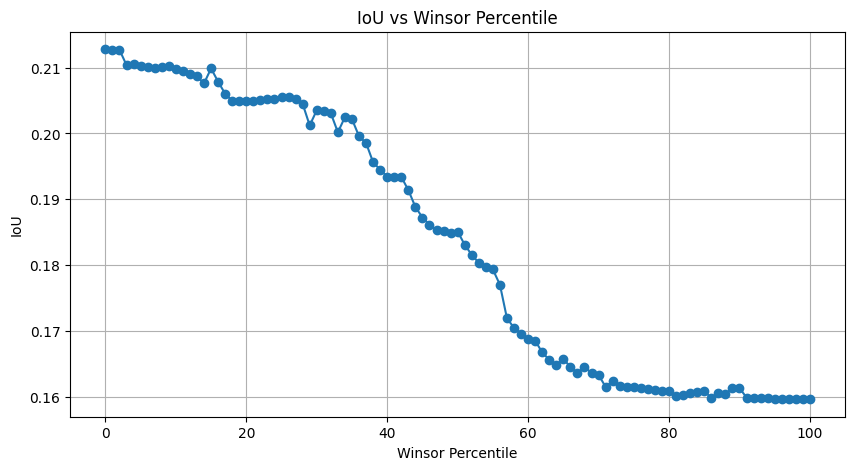

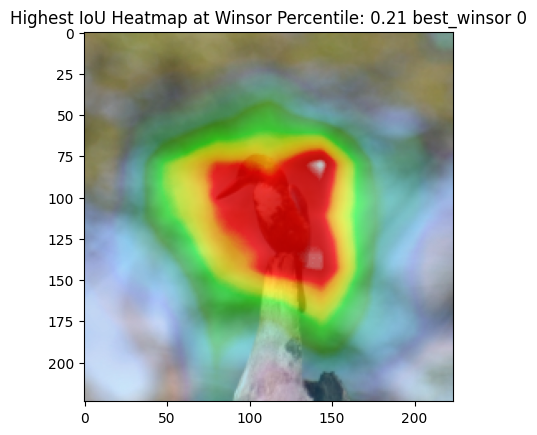

In [ ]:
input_tensor, label, one_hot, indx= single_class_indices_val_subset_efficient[index]
# First run YOUR implementation (with fresh hooks)
model = model.to(device)
model.storage.clear()  # Ensure storage is clear
model._unregister_hooks()  # Remove any existing hooks
model._register_hooks()    # Register fresh hooks

model.eval()
with torch.no_grad():
    output = model(input_tensor.to(device).unsqueeze(0))
predicted_class = torch.argmax(output).item()
sample_label = torch.argmax(one_hot).item()
print(f"Predicted class: {predicted_class}")
print(f"predicted class name:{classes[predicted_class]}")
# print(f"Sample label: {sample_label}")
# raise ValueError("Stop here")
# print(labels)

# print(f"actual label: {labels[sample_label]}")
# print(f"predicted label: {labels[predicted_class]}")

model.storage.clear()  # Ensure storage is clear
model._unregister_hooks()  # Remove any existing hooks
model._register_hooks()    # Register fresh hooks

# use get_gradcams_and_importance
stacked_gradcam, gradcams, importance_tensor = model.get_gradcams_and_importance(input_tensor.to(device).unsqueeze(0),
                                                                                 predicted_class, layer_names,
                                                                                 gradient_aggregation_method,
                                                                                 layer_aggregation_method, True,
                                                                                 interpolation_mode=interpolation_mode)

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
unnormalized_image = input_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)
unnormalized_image = std * unnormalized_image + mean
unnormalized_image = np.clip(unnormalized_image, 0, 1)

# Function to calculate IoU between predicted mask and ground truth
def calculate_iou(winsor_gradcam, label, input_tensor, interpolation_mode):
    thing_to_mask = winsor_gradcam
    if thing_to_mask.shape != input_tensor.shape[2:]:
        thing_to_mask = F.interpolate(thing_to_mask.unsqueeze(0).unsqueeze(0), 
                                     size=input_tensor.shape[1:], 
                                     mode=interpolation_mode).squeeze()
    
    binary_mask = make_binary_mask(thing_to_mask.squeeze())

    # Process target to create proper binary mask
    target = label.permute(1, 2, 0)  # Change to (H, W, C)

    # Check if there are any non-zero pixels in the target
    # This will create a binary mask where any non-black pixel becomes 1
    target = torch.where(
        (target[:,:,0] > 0) | (target[:,:,1] > 0) | (target[:,:,2] > 0),
        torch.tensor(1, dtype=torch.uint8),
        torch.tensor(0, dtype=torch.uint8)
    )
    narrowed_target = torch.Tensor(target).to(torch.uint8).squeeze()
    binary_mask = torch.Tensor(binary_mask).to(torch.uint8).squeeze()

    # Calculate intersection over union
    intersection = torch.logical_and(binary_mask, narrowed_target)
    union = torch.logical_or(binary_mask, narrowed_target)
    iou = intersection.sum() / union.sum() if union.sum() > 0 else 0
    return iou.item()

# so that I can graph the change per winsor value make a list that can be appended to
winsor_ious = []
highest_iou = 0
best_winsor = 0
highest_iou_heatmap = -np.inf
# i want to do 0 to 100 in increments of 1
# test=np.arange(0, 101, 1)
# Generate GradCAMs for different winsor percentiles and calculate IoU
for winsor in np.arange(0, 101, 1):
    winsor_gradcam, _ = model.winsorize_stacked_gradcam(input_tensor.unsqueeze(0), stacked_gradcam, gradcams, 
                                                   importance_tensor, 
                                                   interpolation_mode=interpolation_mode, 
                                                   winsor_percentile=winsor)
    # Create a colored heatmap
    heatmap = create_colored_heatmap(winsor_gradcam, size=(224, 224), 
                                    colormap=map_color, 
                                    op_multiplier=map_opacity_multiplier)


    # Calculate IoU between prediction and ground truth
    iou = calculate_iou(winsor_gradcam, label, input_tensor.squeeze(), interpolation_mode)
    if iou > highest_iou:
        highest_iou = iou
        best_winsor = winsor
        highest_iou_heatmap = heatmap
        # print(f"Highest IoU: {iou:.4f} at Winsor Percentile: {winsor}")
    # print(f"Winsor percentile: {winsor}, IoU: {iou:.4f}")
    winsor_ious.append((winsor, iou))

# Plot the IoU values
plt.figure(figsize=(10, 5))
plt.plot([x[0] for x in winsor_ious], [x[1] for x in winsor_ious], marker='o')
plt.title('IoU vs Winsor Percentile')
plt.xlabel('Winsor Percentile')
plt.ylabel('IoU')
plt.grid()
show()
# show the highest iou heatmap
imshow(unnormalized_image)
imshow(heatmap)
plt.title(f'Highest IoU Heatmap at Winsor Percentile: {highest_iou:.2f} best_winsor {best_winsor}')
show()



Predicted class: 2
predicted class name:bird
torch.Size([224, 224])


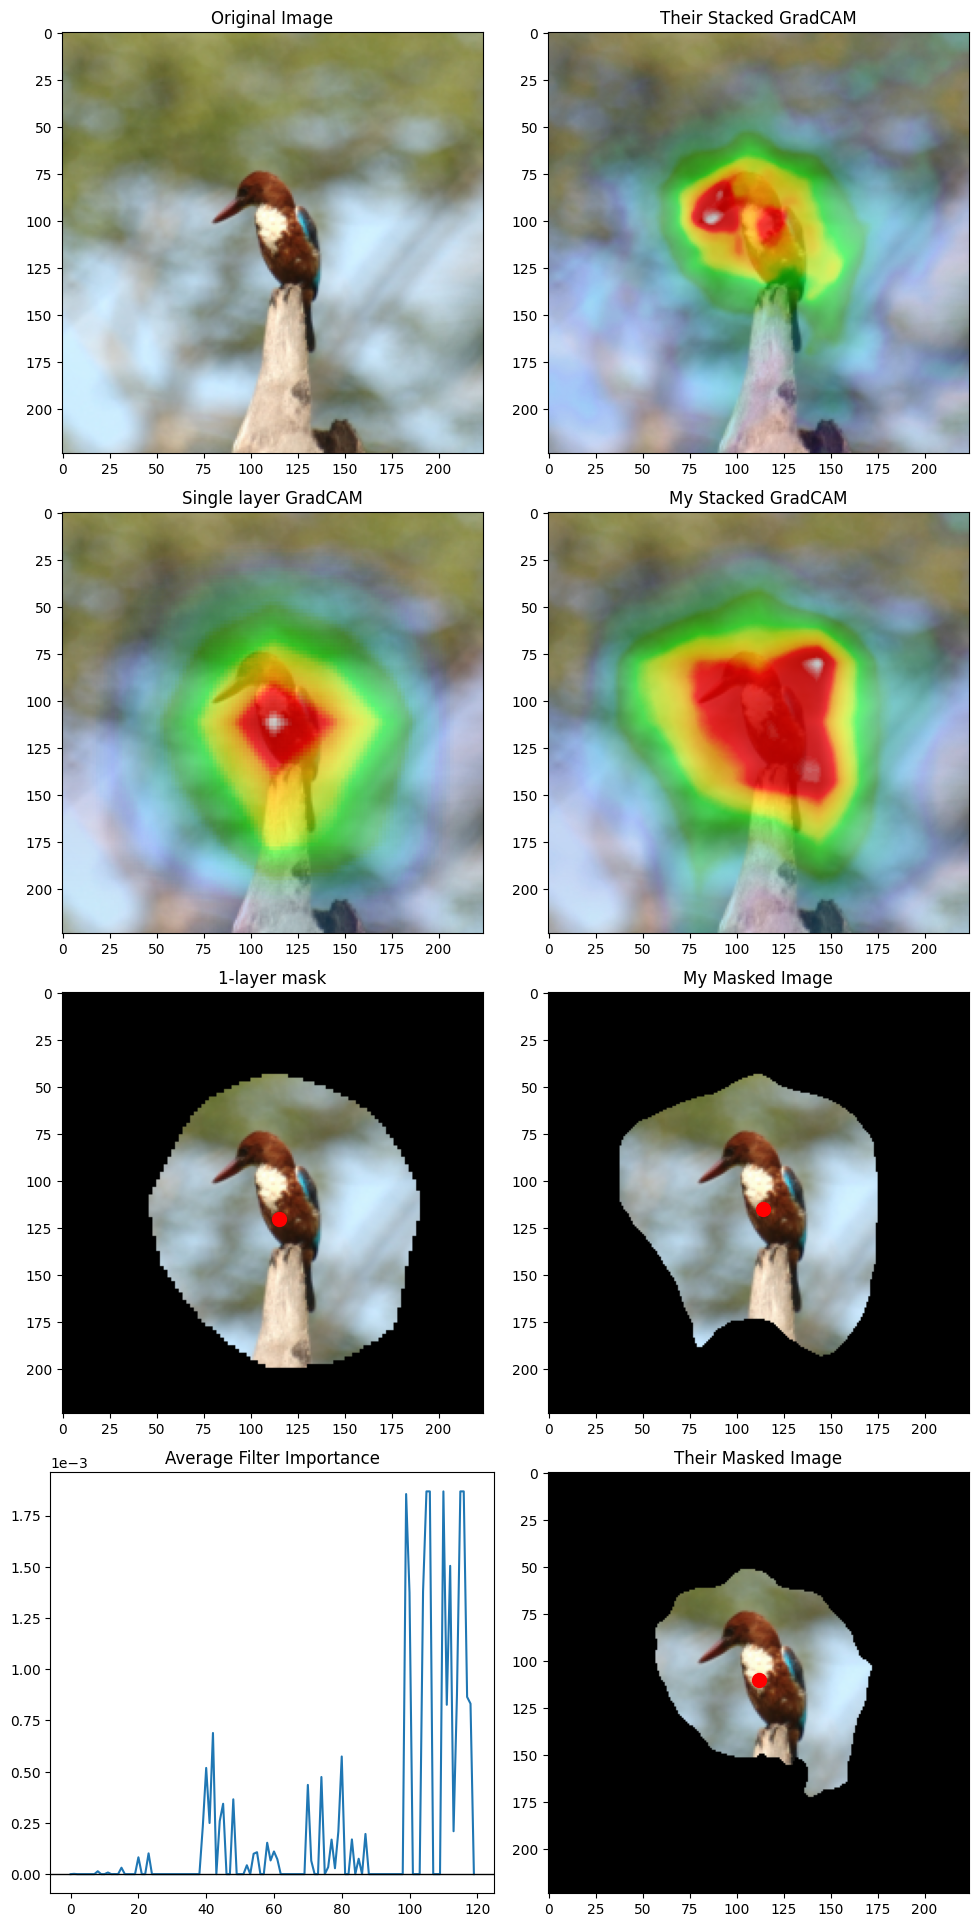

In [ ]:
# I am just going to make a method that takes in the model, dataset, image number, class index, layer names, gradient aggregation method, stack aggregation method, layer aggregation method, stack relu, winsor percentile, and colormap shows the figure from before
def show_gradcam(model, dataset, image_number, class_index,
                 layer_names, gradient_aggregation_method,
                 stack_aggregation_method, layer_aggregation_method, 
                 stack_relu, winsor_percentile,
                 interpolation_mode='nearest', labels = None,
                 map_color = "Reds", map_opacity_multiplier = .9):
    # # # Get image and prepare it
    # print(dataset[image_number])
    # raise ValueError("Stop here")
    input_tensor, label, one_hot, indx = dataset[image_number]
    input_tensor = input_tensor.unsqueeze(0).to(device)
    model = model.to(device)
    
    # First run YOUR implementation (with fresh hooks)
    model.storage.clear()  # Ensure storage is clear
    model._unregister_hooks()  # Remove any existing hooks
    model._register_hooks()    # Register fresh hooks
    
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
    predicted_class = torch.argmax(output).item()
    sample_label = torch.argmax(one_hot).item()
    print(f"Predicted class: {predicted_class}")
    print(f"predicted class name:{classes[predicted_class]}")
    # print(f"Sample label: {sample_label}")
    # raise ValueError("Stop here")
    # print(labels)
    
    # print(f"actual label: {labels[sample_label]}")
    # print(f"predicted label: {labels[predicted_class]}")
    
    model.storage.clear()  # Ensure storage is clear
    model._unregister_hooks()  # Remove any existing hooks
    model._register_hooks()    # Register fresh hooks

    
    stacked_gradcam, gradcams, importance_tensor = model.get_gradcams_and_importance(input_tensor.to(device),
                                                        predicted_class, layer_names,
                                                        gradient_aggregation_method,
                                                        layer_aggregation_method, True,
                                                        interpolation_mode=interpolation_mode)



    winsor_gradcam, grads = model.winsorize_stacked_gradcam(input_tensor, stacked_gradcam, gradcams, 
                                                       importance_tensor, 
                                                       interpolation_mode=interpolation_mode, 
                                                       winsor_percentile=winsor_percentile)
    

    model.storage.clear()  # Ensure storage is clear
    model._unregister_hooks()  # Remove any existing hooks
    model._register_hooks()    # Register fresh hooks
    
    # make base model equal to a copy of the model (ensuing it is just a copy)
    base_model = model.base_model
    
    # Reshape all gradcams to the size of the image
    heatmap = [F.interpolate(gradcam.unsqueeze(0).unsqueeze(0), size=input_tensor.shape[2:], mode=interpolation_mode).squeeze(0).squeeze(0) for gradcam in gradcams]
    # Now stack the gradcams
    heatmap = torch.stack(heatmap)
    # Take the mean of the gradcams
    heatmap= torch.mean(heatmap, dim=0)


    # I need to have a grid of images
    # 6 images in 2 columns and 4 rows
    # make the grid

    #make the grid
    fig, axs = plt.subplots(4, 2, figsize=(10, 20))
    import numpy as np
    # Unnormalize the image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    unnormalized_image = input_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)
    unnormalized_image = std * unnormalized_image + mean
    unnormalized_image = np.clip(unnormalized_image, 0, 1)

    plt.subplot(4, 2, 1)
    plt.imshow(unnormalized_image)
    plt.title("Original Image")

    plt.subplot(4, 2, 2)

    # show the image
    plt.imshow(unnormalized_image)
    plt.imshow(create_colored_heatmap(heatmap.squeeze(), size=input_tensor.shape[2:], colormap=map_color, op_multiplier=map_opacity_multiplier))
    plt.title("Their Stacked GradCAM")


    plt.subplot(4, 2, 4)
    # # show the gradcam_color
    plt.imshow(unnormalized_image, alpha=1)
    # print the min and max of the gradcam
    plt.imshow(create_colored_heatmap(winsor_gradcam, size=input_tensor.shape[2:], op_multiplier=map_opacity_multiplier, colormap=map_color))
    plt.title("My Stacked GradCAM")



    plt.subplot(4, 2, 3)
    plt.imshow(unnormalized_image, alpha=1)
    # normalize the gradcam[-1]
    plt.imshow(create_colored_heatmap(gradcams[-1], size=input_tensor.shape[2:], op_multiplier=map_opacity_multiplier, colormap=map_color))
    plt.title("Single layer GradCAM")


    plt.subplot(4, 2, 4)
    # # show the gradcam_color
    plt.imshow(unnormalized_image, alpha=1)
    # print the min and max of the gradcam
    plt.imshow(create_colored_heatmap(winsor_gradcam, size=input_tensor.shape[2:], op_multiplier=map_opacity_multiplier, colormap=map_color))
    plt.title("My Stacked GradCAM")



    plt.subplot(4, 2, 7)

    plt.plot(grads)
    # on the y axis use scientific notation
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    # put a line at 0
    plt.axhline(0, color='black', lw=1)
    plt.title("Average Filter Importance")


    stacked_gradcam_np = winsor_gradcam.cpu().numpy()
        
    # Generate masked image
    masked_image = generate_masked_image(unnormalized_image, stacked_gradcam_np)
    # insert the centroid of the heatmap
    plt.subplot(4, 2, 5)

    # plt.imshowgradcam[0][0]

    their_mask = generate_masked_image(unnormalized_image, gradcams[-1])

    plt.imshow(their_mask)
    # reshape the gradcam to the size of the image
    resized = F.interpolate(gradcams[-1].unsqueeze(0).unsqueeze(0), size=input_tensor.shape[2:], mode='nearest').squeeze()
    plt.scatter(*find_heatmap_centroid(resized), color='red', s=100)
    plt.title("1-layer mask")



    plt.subplot(4, 2, 6)
    plt.imshow(masked_image)
    print(winsor_gradcam.shape)
    plt.scatter(*find_heatmap_centroid(winsor_gradcam), color='red', s=100)
    plt.title("My Masked Image")


    # their mask

    their_mask = generate_masked_image(unnormalized_image, heatmap.squeeze())
    plt.subplot(4, 2, 8)
    plt.imshow(their_mask)
    plt.scatter(*find_heatmap_centroid(heatmap.squeeze()), color='red', s=100)
    plt.title("Their Masked Image")
    # make an over all title that says GradCAM mapping for the class ...
    # plt.suptitle(f"GradCAM mapping for class {labels[predicted_class] if class_index is None else labels[class_index]}, "
    #              f"Label: {labels[sample_label]}, Predicted: {labels[predicted_class]}")
    plt.tight_layout()
    # add some space between the upper title and the subplots
    plt.subplots_adjust(top=0.95)
    plt.show()



    # print(input_tensor.shape)
    # # now show the saliency map
    # salience_map = model.generate_saliency_map(input_tensor, predicted_class)
    # plt.imshow(unnormalized_image, alpha=1)
    # plt.imshow(create_colored_heatmap(salience_map, size=input_tensor.shape[2:], op_multiplier=1, colormap=map_color))


    plt.show()



# use the function
show_gradcam(model, single_class_indices_val_subset_efficient, index, class_index, layer_names,
             gradient_aggregation_method, stack_aggregation_method,
             layer_aggregation_method, stack_relu, winsor_percentile,
             interpolation_mode=interpolation_mode, labels=pascal_voc_classes,
             map_color=map_color, map_opacity_multiplier=map_opacity_multiplier)



Predicted class: 2
predicted class name:bird
actual class: bird


Generating GradCAMs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:46<00:00,  2.19winsor/s]


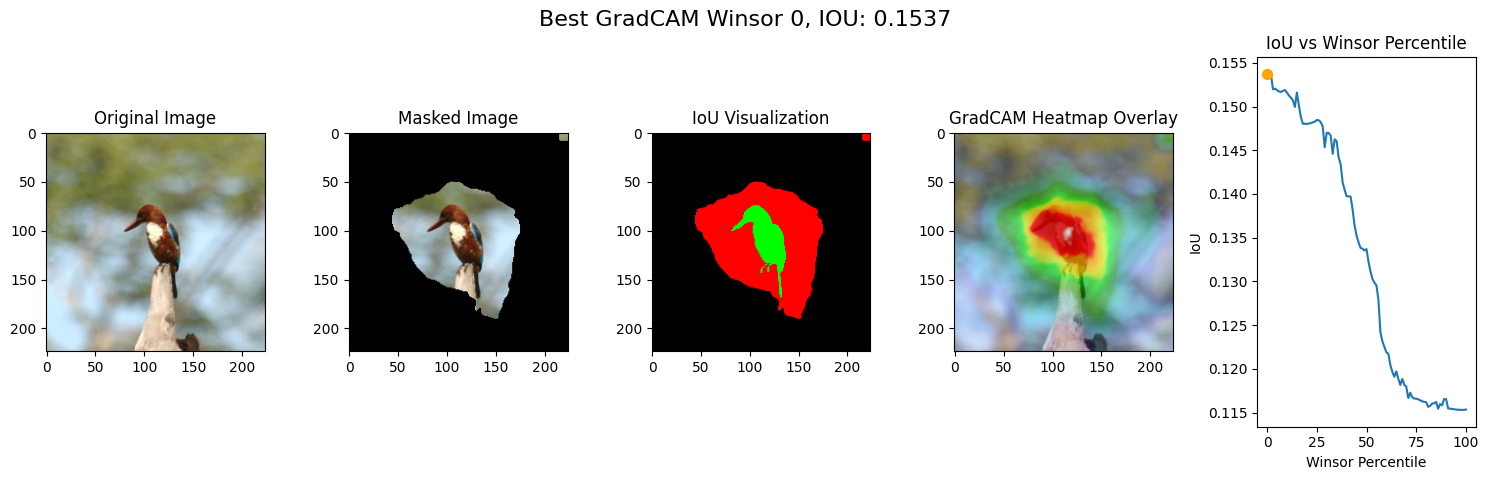

In [ ]:

def generate_gradcam_gif(model, dataset, index, class_index, layer_names,
                         gradient_aggregation_method, stack_aggregation_method,
                         layer_aggregation_method, stack_relu, 
                         interpolation_mode='nearest',
                         temp_dir="temp", gif_name="gradcam.gif", labels=None,
                         map_color="Reds", map_opacity_multiplier=1.,
                         needed_class=None, winsor_range=np.arange(0, 101, 10)):
    """
    Generate a GradCAM GIF for different winsor percentiles.

    Args:
        model: The model to generate GradCAMs from
        dataset: The dataset to generate GradCAMs for
        index: The index of the image in the dataset
        class_index: The index of the class to generate
        layer_names: The names of the layers to generate GradCAMs for
        gradient_aggregation_method: The method to aggregate gradients
        stack_aggregation_method: The method to aggregate stacked GradCAMs
        layer_aggregation_method: The method to aggregate layer GradCAMs
        stack_relu: Whether to apply ReLU to stacked GradCAMs
        interpolation_mode: The interpolation mode for resizing
        temp_dir: The temporary directory to store images
        gif_name: The name of the output
    """
    
    # Create a temporary directory to store the images
    os.makedirs(temp_dir, exist_ok=True)


    input_tensor, label, one_hot, indx = dataset[index]
    label = fix_label(label.squeeze().cpu())
    input_tensor = input_tensor.unsqueeze(0)
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    unnormalized_image = input_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)
    unnormalized_image = std * unnormalized_image + mean
    unnormalized_image = np.clip(unnormalized_image, 0, 1)

    model.to(device)
    input_tensor = input_tensor.to(device)
    
    # sample_label = torch.argmax(one_hot).item()
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
    predicted_class = torch.argmax(output).item()
    print(f"Predicted class: {predicted_class}")
    print(f"predicted class name:{classes[predicted_class]}")
    # using argmax on the one hot get the actual class
    print(f"actual class: {classes[torch.argmax(one_hot).item()]}")
    model.storage.clear()  # Ensure storage is clear
    model._unregister_hooks()  # Remove any existing hooks
    model._register_hooks()    # Register fresh hooks
    stacked_gradcam, gradcams, importance_tensor = model.get_gradcams_and_importance(input_tensor.to(device),
                                                        predicted_class, layer_names,
                                                        gradient_aggregation_method,
                                                        layer_aggregation_method, True,
                                                        interpolation_mode=interpolation_mode)
    glob_iou = []
    best_winsor = 0
    best_iou = 0
    for winsor in tqdm(winsor_range, desc="Generating GradCAMs", unit="winsor"):
        winsor_gradcam, grads = model.winsorize_stacked_gradcam(input_tensor, stacked_gradcam, gradcams, 
                                                       importance_tensor, 
                                                       interpolation_mode=interpolation_mode, 
                                                       winsor_percentile=winsor)
        glob_iou.append(calculate_iou(winsor_gradcam, label.permute(2, 0, 1), input_tensor, interpolation_mode))
        if glob_iou[-1] > best_iou:
            best_iou = glob_iou[-1]
            best_winsor = winsor


        
    best_mask = None
    best_image = None
    best_winsor_gradcam = None

    # Generate GradCAMs for different winsor percentiles
    for winsor in tqdm(winsor_range, desc="Generating GradCAMs", unit="winsor"):
        winsor_gradcam, grads = model.winsorize_stacked_gradcam(input_tensor, stacked_gradcam, gradcams, 
                                                       importance_tensor, 
                                                       interpolation_mode=interpolation_mode, 
                                                       winsor_percentile=winsor)
        

        # i need the mask of the stacked gradcam
        mask_of_winsor = make_binary_mask(winsor_gradcam.squeeze())
        # imshow(masked_mask_of_winsor)
        # show()
        
        # take the label and make it so that where there is tensor([0., 0., 0.]) it is 0 on a binary mask
        # and where there is tensor([1., 1., 1.]) it is 1 on a binary mask
        binary_mask = torch.where(
            (label[:,:,0] > 0) | (label[:,:,1] > 0) | (label[:,:,2] > 0),
            torch.tensor(1, dtype=torch.uint8),
            torch.tensor(0, dtype=torch.uint8)
        )

        # now that I have the binary mask and a mask of the winsor gradcam I want to visualize the iou
        # where there is intersection I want to make it green


        intersection = torch.logical_and(torch.tensor(mask_of_winsor), binary_mask)


        # Create a colored image where the intersection is green
        colored_image = np.zeros((*input_tensor.shape[2:], 3))  # Adjust shape for RGB

        # Where there is a difference, make it red
        colored_image[torch.logical_xor(torch.tensor(mask_of_winsor), binary_mask)] = [1, 0, 0]


        # Where there is the binary mask but not in the intersection, make it blue
        only_binary = torch.logical_and(binary_mask, ~torch.tensor(mask_of_winsor))
        colored_image[only_binary] = [0, 0, 1]  # Blue

        colored_image[intersection] = [0, 1, 0]  # Green

        # calculate_iou the iou using the intersection and the union
        union = torch.logical_or(torch.tensor(mask_of_winsor), binary_mask)
        iou = intersection.sum() / union.sum() if union.sum() > 0 else 0

        if winsor == best_winsor:
            best_winsor_gradcam = winsor_gradcam
            best_mask = mask_of_winsor
            best_colored_image = colored_image
            


        # Create a figure with 3 subplots
        fig, ax = plt.subplots(1, 5, figsize=(15, 5))
        fig.suptitle(f"GradCAM Winsor {winsor}, IOU: {iou:.4f}", fontsize=16, y=0.95)
        
        ax[0].imshow(unnormalized_image)
        ax[0].imshow(create_colored_heatmap(winsor_gradcam.squeeze(), op_multiplier=map_opacity_multiplier, colormap=map_color))
        ax[0].set_title("Original Image with GradCAM")
        
        masked_image = generate_masked_image(unnormalized_image, winsor_gradcam.squeeze())
        ax[1].imshow(masked_image)
        ax[1].set_title("Masked Image")
        
        ax[2].imshow(colored_image)
        ax[2].set_title("IoU Visualization")
        
        ax[3].plot(grads.squeeze().cpu().numpy())
        ax[3].set_title("Gradient Magnitudes")
        
        ax[4].plot(winsor_range, glob_iou)
        ax[4].scatter(winsor, iou, c='orange', marker='o', s=50, zorder=5)
        ax[4].set_title("IoU vs Winsor Percentile")
        ax[4].set_xlabel("Winsor Percentile")
        ax[4].set_ylabel("IoU")

        plt.savefig(os.path.join(temp_dir, f"{winsor}.png"))
        plt.close()

    # Create a GIF from the saved images
    image_files = [os.path.join(temp_dir, f"{winsor}.png") for winsor in winsor_range]
    images = [imageio.v2.imread(file) for file in image_files]
    imageio.mimsave(gif_name, images, duration=1000)

    # Remove the temporary directory
    shutil.rmtree(temp_dir)

    # make a figure that shows the unnormalized_image best_winsor_gradcam mask_of_winsor best_colored_image, best_mask, and the plot(winsor_range, glob_iou) with dot
    fig, ax = plt.subplots(1, 5, figsize=(15, 5))
    fig.suptitle(f"Best GradCAM Winsor {best_winsor}, IOU: {best_iou:.4f}", fontsize=16, y=0.95)
    
    # Original image
    ax[0].imshow(unnormalized_image)
    ax[0].set_title("Original Image")
    
    # Masked image
    masked_image = generate_masked_image(unnormalized_image, best_winsor_gradcam.squeeze())
    ax[1].imshow(masked_image)
    ax[1].set_title("Masked Image")
    
    # IoU visualization
    ax[2].imshow(best_colored_image)
    ax[2].set_title("IoU Visualization")
    
    # GradCAM heatmap overlay
    ax[3].imshow(unnormalized_image)
    ax[3].imshow(create_colored_heatmap(best_winsor_gradcam.squeeze(), op_multiplier=map_opacity_multiplier, colormap=map_color))
    ax[3].set_title("GradCAM Heatmap Overlay")
    
    # IoU vs Winsor Percentile plot
    ax[4].plot(winsor_range, glob_iou)
    ax[4].scatter(best_winsor, best_iou, c='orange', marker='o', s=50, zorder=5)
    ax[4].set_title("IoU vs Winsor Percentile")
    ax[4].set_xlabel("Winsor Percentile")
    ax[4].set_ylabel("IoU")
    
    plt.tight_layout()



    plt.show()




generate_gradcam_gif(model, single_class_indices_val_subset_efficient, index, class_index, layer_names,
                     gradient_aggregation_method, stack_aggregation_method,
                     layer_aggregation_method, stack_relu, 
                     interpolation_mode=interpolation_mode,
                     temp_dir="temp", gif_name="./examples/winsorcam_pascalvoc.gif", labels=pascal_voc_classes,
                     map_color=map_color, map_opacity_multiplier=map_opacity_multiplier,
                     needed_class=None, winsor_range=np.arange(0, 101, 1))